In [1]:
!sudo pip3 install contractions
!sudo pip3 install textsearch
!sudo pip3 install tqdm
!sudo pip3 install nltk
!sudo pip3 install beautifulsoup4
import nltk
nltk.download('punkt')

     |████████████████████████████████| 245kB 4.1MB/s 
     |████████████████████████████████| 317kB 7.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81705 sha256=ca130bc61cc6f72e3cdb1305d5cf0f63c3dabe1fb81857a4c12546d528ba9cad
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding
print(tf.__version__)
import io
import os

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


2.3.0


In [6]:
from google.colab import files
uploaded = files.upload()

Saving FoodReviews.csv to FoodReviews.csv


In [8]:
FoodReviews = pd.read_csv(io.BytesIO(uploaded['FoodReviews.csv']))
print(f'FoodReviews is loaded')

FoodReviews is loaded


In [9]:
FoodReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170536 entries, 0 to 170535
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      170536 non-null  int64 
 1   ProductId               170536 non-null  object
 2   UserId                  170536 non-null  object
 3   ProfileName             170532 non-null  object
 4   HelpfulnessNumerator    170536 non-null  int64 
 5   HelpfulnessDenominator  170536 non-null  int64 
 6   Score                   170536 non-null  int64 
 7   Time                    170536 non-null  int64 
 8   Summary                 170527 non-null  object
 9   Text                    170536 non-null  object
dtypes: int64(5), object(5)
memory usage: 13.0+ MB


In [10]:
FoodReviews['score'] = np.where(FoodReviews['Score']<=3,0,1)

In [11]:
# Random shuffle
FoodReviews = FoodReviews.sample(frac=1, random_state=100).reset_index(drop=True)

reviews = FoodReviews['Text'].values
sentiments = FoodReviews['score'].values

training_size = int(len(reviews)*0.7)
valid_size = int(len(reviews)*0.8)

train_reviews = reviews[:training_size]
val_reviews = reviews [training_size:valid_size]
test_reviews = reviews[valid_size:]

train_sentiments = sentiments[:training_size]
val_sentiments = sentiments [training_size:valid_size]
test_sentiments = sentiments[valid_size:]

train_reviews.shape, val_reviews.shape, test_reviews.shape

((119375,), (17053,), (34108,))

In [12]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = re.sub(r'https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)
        doc = re.sub(r'\<a href', ' ', doc)
        doc = re.sub(r'&amp;', '', doc) 
        doc = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', doc)
        doc = re.sub(r'<br />', ' ', doc)
        doc = re.sub(r'\'', ' ', doc)
        doc = doc.strip()  
        norm_docs.append(doc)
    return norm_docs

In [13]:
process_train_texts = pre_process_corpus(train_reviews)
process_val_texts = pre_process_corpus(val_reviews)
process_test_texts = pre_process_corpus(test_reviews)

100%|██████████| 34108/34108 [00:07<00:00, 4331.38it/s]


(0.0, 750.0)

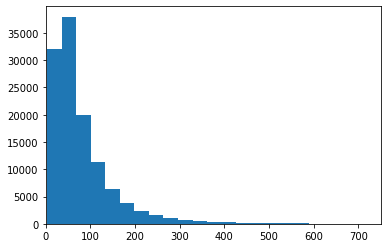

In [14]:
# Histogram of length of reviews in Train data
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len(doc.split()) for doc in process_train_texts], bins=50);
plt.xlim([0, 750])

In [15]:
# maxlen can be chosen based on the histogram of length of reviews in Train data
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(process_train_texts)

word_index = tokenizer.word_index

train_sequences  = tokenizer.texts_to_sequences(process_train_texts)
train_padded = pad_sequences(train_sequences , maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences  = tokenizer.texts_to_sequences(process_val_texts)
val_padded = pad_sequences(val_sequences , maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(process_test_texts)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2020-11-20 02:43:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-20 02:43:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-20 02:44:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [17]:
# path of the downloaded embedding vectors
!ls
!pwd

FoodReviews.csv    glove.6B.200d.txt  glove.6B.50d.txt	Reviews.csv
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip	sample_data
/content


In [38]:
from numpy import asarray

# load embedding as a dict
def load_embedding(filename):
	# load embedding into memory, skip first line
	file = open(filename,'r')
	lines = file.readlines()
	file.close()
	# create a map of words to vectors
	embedding = dict()
	for line in lines:
		parts = line.split()
		# key is string word, value is numpy array for vector
		embedding[parts[0]] = asarray(parts[1:], dtype='float32')
	return embedding

In [39]:
from numpy import zeros
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
	# total vocabulary size plus 0 for unknown words
	vocab_size = len(vocab) + 1
	# define weight matrix dimensions with all 0
	weight_matrix = zeros((vocab_size, 100))
	# step vocab, store vectors using the Tokenizer's integer mapping
	for word, i in vocab.items():
		vector = embedding.get(word)
		if vector is not None:
			weight_matrix[i] = vector
	return weight_matrix

In [41]:
vocab = word_index
vocab_size = len(word_index)+1
# load embedding from file
raw_embedding = load_embedding('glove.6B.100d.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [42]:
# define model
model = tf.keras.models.Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          6610200   
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 12545     
Total params: 6,686,873
Trainable params: 76,673
Non-trainable params: 6,610,200
_________________________________________________________________
None


In [47]:
# fit network
n_epochs=12
batches=128

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(train_padded, train_sentiments,validation_data=(val_padded, val_sentiments),  epochs=n_epochs, batch_size= batches, verbose=2)

Epoch 1/12
933/933 - 5s - loss: 0.0067 - accuracy: 0.9987 - val_loss: 1.2800 - val_accuracy: 0.8807
Epoch 2/12
933/933 - 5s - loss: 0.0057 - accuracy: 0.9990 - val_loss: 1.2827 - val_accuracy: 0.8775
Epoch 3/12
933/933 - 5s - loss: 0.0067 - accuracy: 0.9989 - val_loss: 1.2724 - val_accuracy: 0.8800
Epoch 4/12
933/933 - 6s - loss: 0.0090 - accuracy: 0.9978 - val_loss: 1.2640 - val_accuracy: 0.8802
Epoch 5/12
933/933 - 5s - loss: 0.0044 - accuracy: 0.9994 - val_loss: 1.2989 - val_accuracy: 0.8797
Epoch 6/12
933/933 - 5s - loss: 0.0088 - accuracy: 0.9983 - val_loss: 1.3273 - val_accuracy: 0.8806
Epoch 7/12
933/933 - 6s - loss: 0.0067 - accuracy: 0.9985 - val_loss: 1.3059 - val_accuracy: 0.8745
Epoch 8/12
933/933 - 5s - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.3328 - val_accuracy: 0.8754
Epoch 9/12
933/933 - 5s - loss: 0.0061 - accuracy: 0.9989 - val_loss: 1.3240 - val_accuracy: 0.8786
Epoch 10/12
933/933 - 6s - loss: 0.0086 - accuracy: 0.9981 - val_loss: 1.3338 - val_accuracy: 0.8738

In [48]:
# Performance on Test data
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = model.predict_classes(test_padded, batch_size=2048, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy: 88.16%
              precision    recall  f1-score   support

           0       0.77      0.66      0.71      7512
           1       0.91      0.94      0.93     26596

    accuracy                           0.88     34108
   macro avg       0.84      0.80      0.82     34108
weighted avg       0.88      0.88      0.88     34108



,0,1
0,4944,2568
1,1470,25126


In [49]:
# define model
model_LSTM = tf.keras.models.Sequential()
model_LSTM.add(embedding_layer)
model_LSTM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_LSTM.add(tf.keras.layers.Dense(64, activation='relu'))
model_LSTM.add(Dense(1, activation='sigmoid'))
print(model_LSTM.summary())
# compile network
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          6610200   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,703,001
Trainable params: 92,801
Non-trainable params: 6,610,200
_________________________________________________________________
None


In [51]:
# fit network
n_epochs=25
batches=128

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)

history = model_LSTM.fit(train_padded, train_sentiments,validation_data=(val_padded, val_sentiments),  epochs=n_epochs, batch_size= batches, verbose=2)

Epoch 1/25
933/933 - 21s - loss: 0.2586 - accuracy: 0.8911 - val_loss: 0.2569 - val_accuracy: 0.8957
Epoch 2/25
933/933 - 21s - loss: 0.2337 - accuracy: 0.9030 - val_loss: 0.2431 - val_accuracy: 0.9022
Epoch 3/25
933/933 - 21s - loss: 0.2162 - accuracy: 0.9112 - val_loss: 0.2340 - val_accuracy: 0.9066
Epoch 4/25
933/933 - 21s - loss: 0.2000 - accuracy: 0.9185 - val_loss: 0.2249 - val_accuracy: 0.9099
Epoch 5/25
933/933 - 21s - loss: 0.1860 - accuracy: 0.9250 - val_loss: 0.2295 - val_accuracy: 0.9108
Epoch 6/25
933/933 - 21s - loss: 0.1746 - accuracy: 0.9307 - val_loss: 0.2373 - val_accuracy: 0.9052
Epoch 7/25
933/933 - 21s - loss: 0.1609 - accuracy: 0.9367 - val_loss: 0.2322 - val_accuracy: 0.9137
Epoch 8/25
933/933 - 21s - loss: 0.1506 - accuracy: 0.9414 - val_loss: 0.2294 - val_accuracy: 0.9140
Epoch 9/25
933/933 - 21s - loss: 0.1392 - accuracy: 0.9465 - val_loss: 0.2313 - val_accuracy: 0.9149
Epoch 10/25
933/933 - 21s - loss: 0.1301 - accuracy: 0.9506 - val_loss: 0.2401 - val_accura

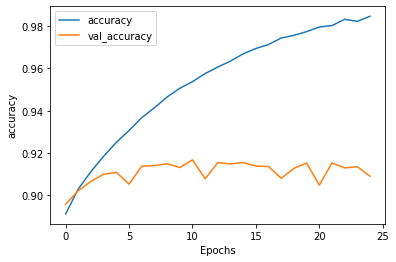

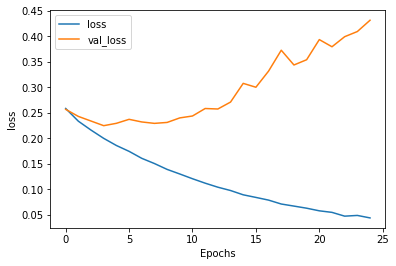

In [52]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [58]:
# define model
model_LSTM = tf.keras.models.Sequential()
model_LSTM.add(embedding_layer)
model_LSTM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_LSTM.add(tf.keras.layers.Dense(64, activation='relu'))
model_LSTM.add(Dense(1, activation='sigmoid'))
print(model_LSTM.summary())
# compile network
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model_LSTM.fit(train_padded, train_sentiments,validation_data=(val_padded, val_sentiments),  epochs=5, batch_size= batches, verbose=2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          6610200   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 6,703,001
Trainable params: 92,801
Non-trainable params: 6,610,200
_________________________________________________________________
None
Epoch 1/5
933/933 - 22s - loss: 0.3881 - accuracy: 0.8273 - val_loss: 0.3193 - val_accuracy: 0.8615
Epoch 2/5
933/933 - 21s - loss: 0.2911 - accuracy: 0.8756 - val_loss: 0.2708 - val_accuracy: 0.8894
Epoch 3/5
933/933 - 21s - loss: 

In [59]:
# Performance on Test data
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = model_LSTM.predict_classes(test_padded, batch_size=2048, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 90.71%
              precision    recall  f1-score   support

           0       0.86      0.69      0.77      7512
           1       0.92      0.97      0.94     26596

    accuracy                           0.91     34108
   macro avg       0.89      0.83      0.85     34108
weighted avg       0.90      0.91      0.90     34108



,0,1
0,5189,2323
1,847,25749
